In [11]:
import numpy as np
from matplotlib import pyplot as plt
import os
import sys
import json 
import re
from decomp import UDSCorpus


miso_path = "/home/hltcoe/estengel/miso_research"
sys.path.insert(0, miso_path)

In [15]:
transformer_data_path = "/exp/estengel/miso_res/new_models/decomp-transformer-best/data.json"
lstm_data_path = "/exp/estengel/miso_res/new_models/decomp-lstm-base/data.json"

with open(transformer_data_path) as tf1, open(lstm_data_path) as lf1:
    tfmr_data = json.load(tf1)
    lstm_data = json.load(lf1)
    
# build ontology
attribute_ontology = list(sorted(tfmr_data.keys()))
    

In [6]:
# need to re-munge output 
# current output: {subspace: {true: {nodes},
#                              pred: {nodes}}
# what we want:
# {sentence: {node_id: {subspace: (true, pred)}}}

def get_sent_id(whole_id):
    sent_id = "-".join(whole_id.split("-")[0:3])
    sent_idx = int(whole_id.split("-")[2])
    return sent_id, sent_idx

def get_node_id(whole_id):
    node_id = "-".join(whole_id.split("-")[3:])
    node_idx = int(whole_id.split("-")[-1])
    return node_id, node_idx

out_dict = {"tfmr": {},
            "lstm": {}}
for model, model_data in zip(["lstm", "tfmr"], [lstm_data, tfmr_data]):
    lil_dict = out_dict[model]
    # loop once to collect all sentence ids and node ids 
    for subspace_id, subspace_dict in model_data.items():
        for whole_id in subspace_dict["true_val_with_node_ids"]:
            sent_id, sent_idx = get_sent_id(whole_id)
            if sent_idx not in lil_dict.keys():
                lil_dict[sent_idx] = {}
            node_id, node_idx = get_node_id(whole_id)
            if node_idx not in lil_dict[sent_idx].keys():
                lil_dict[sent_idx][node_idx] = {}
                
            true_node_value = subspace_dict["true_val_with_node_ids"][whole_id]
            pred_node_value = subspace_dict["pred_val_with_node_ids"][whole_id]
            lil_dict[sent_idx][node_idx][subspace_id] = (true_node_value, pred_node_value)
            
    out_dict[model] = lil_dict
            

dict_keys([4, 3, 6])


In [13]:
corpus = UDSCorpus(split="dev")

def get_midpoint(sent_idx):
    sent_id = f"ewt-dev-{sent_idx}"
    graph = corpus[sent_id]
    sent = re.split("\s+", graph.sentence) 
    midpoint = len(sent)/2
    return midpoint
    
midpoint_dict = {"lstm": {},
                 "tfmr": {}}
# for each sentence, get midpoint 
for model in midpoint_dict.keys():
    for sent_idx in out_dict[model].keys():
        midpoint = get_midpoint(sent_idx)
        midpoint_dict[model][sent_idx] = midpoint


3.5


In [25]:
# group pred and true values into buckets by distance from midpoint 
# bucket_dict: {distance: [subspace: (true, pred)...]}
from collections import defaultdict
bucket_dict = {"lstm": defaultdict(lambda: defaultdict(lambda: defaultdict(list))),
               "tfmr": defaultdict(lambda: defaultdict(lambda: defaultdict(list)))}

for model, model_data in out_dict.items():
    for sent_idx, sent_data in model_data.items():
        midpoint = midpoint_dict[model][sent_idx]
        for node_idx, node_data in sent_data.items():
            # normalize nodes to be 0-indexed 
            node_idx = node_idx - 1
            distance = int(midpoint - node_idx) 

            true_data = np.ones(len(node_data)) 
            pred_data = np.ones(len(node_data)) 
            
            for subspace, (tv, pv) in node_data.items():
                bucket_dict[model][distance][subspace]["true"].append(tv)
                bucket_dict[model][distance][subspace]["pred"].append(pv)


print(bucket_dict['tfmr'][0]["factuality-factual"]["true"][0:10])
print(bucket_dict['tfmr'][0]["factuality-factual"]["pred"][0:10])

            


[0.967, 1.2089, 1.2089, 1.1329, 1.0583, 1.0835, 1.0834, 0.0912, 0.1502, -1.1059]
[0.9637286067008972, 1.0221346616744995, 1.0215191841125488, 1.0856925249099731, 0.9973695278167725, 1.0027951002120972, 0.890845000743866, -1.1816179752349854, -0.1315755695104599, -1.015701413154602]


In [47]:
from scipy.stats import pearsonr 

# compute pearson for each bucket 
pearson_data = defaultdict(lambda: defaultdict(list))
for model_name, model_bucket_dict in bucket_dict.items():
    for distance, distance_dict in model_bucket_dict.items():
        for subspace, subspace_dict in distance_dict.items():
            true_vals = np.array(subspace_dict["true"])
            pred_vals = np.array(subspace_dict["pred"])
            if len(true_vals) > 10:
                assert(len(true_vals) == len(pred_vals))
            else:
                continue
            rho, p_val = pearsonr(true_vals, pred_vals)
            if np.isnan(rho):
                continue 
            if rho < 0:
                # skip for now
                continue
                
            if p_val < 0.05:
                pearson_data[model_name][distance].append(rho)

for model, model_pearson_data in pearson_data.items():
    for distance, distance_rhos in model_pearson_data.items():
        avg_rho = np.mean(distance_rhos)
        model_pearson_data[distance] = avg_rho
    pearson_data[model] = model_pearson_data
#         pearson_data[model][distance] = avg_rho 
    
print(pearson_data.keys())
print(pearson_data['tfmr'])



dict_keys(['lstm', 'tfmr'])
defaultdict(<class 'list'>, {0: 0.6219153019403822, 1: 0.6587174868085449, -1: 0.66866315843719, 5: 0.6658973687163535, 8: 0.745223036608054, 6: 0.6966717354172496, 3: 0.6675080289583945, 13: 0.8136022675698553, -9: 0.7458160538139034, 14: 0.7856340921660527, 10: 0.6898732278272636, 4: 0.648197158666344, -12: 0.8661908807551243, -10: 0.747166334460197, 15: 0.5157399102967165, -13: 0.9126609107485586, 9: 0.7700349890827861, -6: 0.7224419671412878, -7: 0.745932894538752, 12: 0.7614114154219884, 7: 0.6800902146769608, -8: 0.7781317972922094, -11: 0.8133568422652447, 11: 0.7646018907143544, 2: 0.6490396822559757, -3: 0.6337823396834102, -4: 0.7018462284724727, -2: 0.677273581459402, -5: 0.7499875842066762, 17: 0.7593207249832028, 16: 0.5611380762619813, 18: 0.690752700077333, -15: 0.5540716149099999, -16: 0.7068283903727753, -14: 0.5344299429565637})


dict_items([(0, 0.556276486469275), (1, 0.6322775424355092), (-1, 0.6013880383626199), (5, 0.6087298144755191), (8, 0.6445496889937945), (6, 0.6434741007624013), (3, 0.5923015721613419), (13, 0.7052162131260579), (-9, 0.7133503063006529), (14, 0.7700777977717379), (10, 0.6376566075785647), (4, 0.6004528541231173), (-12, 0.7948052285825742), (-10, 0.6368011087192788), (15, 0.5152961606791485), (-13, 0.7880121695383546), (9, 0.7579871845072069), (-6, 0.6569042670008093), (-7, 0.6065309661635017), (12, 0.7005513505752906), (7, 0.6218645415914352), (-8, 0.6913047479129192), (-11, 0.78171091938577), (11, 0.6413996104416766), (2, 0.5617181909650077), (-3, 0.5983631650823014), (-4, 0.6267397448707195), (-2, 0.5801032639898537), (-5, 0.6432617182407898), (16, 0.5946841100902392), (-16, 0.5900224333210741), (-14, 0.591336264247167)])
dict_items([(0, 0.6219153019403822), (1, 0.6587174868085449), (-1, 0.66866315843719), (5, 0.6658973687163535), (8, 0.745223036608054), (6, 0.6966717354172496), (3,

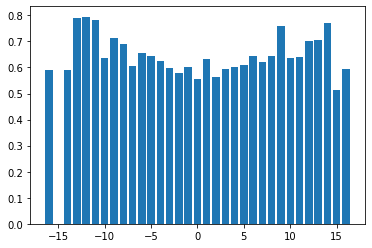

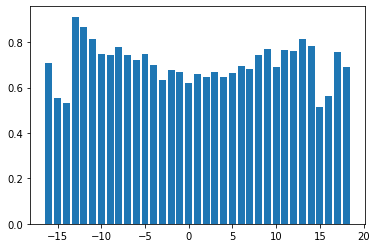

In [48]:
# plot separately 
def plot(pearson_dict):
    plt.figure()
    # sort by distance 
    print(pearson_dict.items())
    distances, pearsons = zip(*sorted(pearson_dict.items(), key = lambda x : x[0]))
    plt.bar(distances, pearsons)

plot(pearson_data['lstm'])
plot(pearson_data['tfmr'])


<BarContainer object of 32 artists>

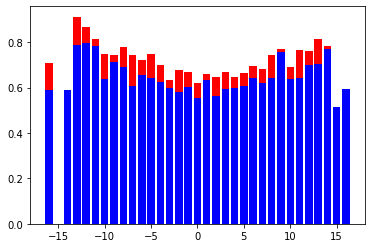

In [54]:
to_plot_xs = []
to_plot_ys_lstm = []
to_plot_ys_tfmr = []


for distance in pearson_data['lstm'].keys():
    if distance in pearson_data['tfmr'].keys():
        to_plot_xs.append(distance)
        to_plot_ys_lstm.append(pearson_data['lstm'][distance])
        to_plot_ys_tfmr.append(pearson_data['tfmr'][distance])

plt.figure()

plt.bar(to_plot_xs, to_plot_ys_tfmr, color='r')
plt.bar(to_plot_xs, to_plot_ys_lstm, color='b')
